In [1]:
import matplotlib.pylab as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 10),
         'axes.labelsize': 13,
         'axes.titlesize':13,
         'xtick.labelsize':13,
         'ytick.labelsize':13,
         'axes.labelweight':'bold',
          'legend.fontsize': 13,
          'font.size':13,
         'figure.max_open_warning': 0}

plt.rcParams.update(params)
import matplotlib.colors as colors

In [2]:
import dask.array as da
from daskms import xds_from_table, xds_to_table
from astropy import units as u
from astropy.time import Time,TimeDelta
from datetime import datetime
import jupyter_capture_output
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.optimize import curve_fit, minimize_scalar

Jupyter Capture Output v0.0.11


In [3]:
# the path to the file:
data_path = ''

In [4]:
# creating x_array dataset from the measurement set
dataset = xds_from_table(data_path+"1548939342.ms")

In [5]:
obs_table = xds_from_table(data_path+"1548939342.ms::OBSERVATION")
print(obs_table)

[<xarray.Dataset> Size: 81B
Dimensions:         (row: 1, schedule: 1, log: 1, obs-exts: 2)
Coordinates:
    ROWID           (row) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: row, schedule, log, obs-exts
Data variables:
    SCHEDULE        (row, schedule) object 8B dask.array<chunksize=(1, 1), meta=np.ndarray>
    PROJECT         (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    TELESCOPE_NAME  (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    LOG             (row, log) object 8B dask.array<chunksize=(1, 1), meta=np.ndarray>
    FLAG_ROW        (row) bool 1B dask.array<chunksize=(1,), meta=np.ndarray>
    OBSERVER        (row) object 8B dask.array<chunksize=(1,), meta=np.ndarray>
    RELEASE_DATE    (row) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    TIME_RANGE      (row, obs-exts) float64 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    SCHEDULE_TYPE   (row) object 8B dask.array<chunksize=(1,), meta=

In [6]:
for key in obs_table[0].keys():

    print(f'{key}: {obs_table[0][key].values}')

SCHEDULE: [['unavailable']]
PROJECT: ['20190131-0012']
TELESCOPE_NAME: ['MeerKAT']
LOG: [['unavailable']]
FLAG_ROW: [False]
OBSERVER: ['Lindsay']
RELEASE_DATE: [5.05565639e+09]
TIME_RANGE: [[5.05565617e+09 5.05565639e+09]]
SCHEDULE_TYPE: ['unknown']


In [7]:
#1) Date and Time of the observation
t_range = obs_table[0]['TIME_RANGE'].values
t_filename = 1548939342 # the filename gives the start time in seconds from 1 January 1970
t_start = (Time(1970,format='jyear')+TimeDelta(t_filename*u.s)).iso# convert to UTC
t_end = t_range[0,1]-t_range[0,0] + t_filename # add difference in time range to starting time to find time at end of observation from 1 January 1970
t_end = (Time(1970,format='jyear')+TimeDelta(t_end*u.s)).iso# convert to UTC
print('Start Date/Time: ',t_start,' End Date/Time: ',t_end)
print('Observation Duration: ',(t_range[0,1]-t_range[0,0])/60,' m')

Start Date/Time:  2019-01-31 12:55:42.000  End Date/Time:  2019-01-31 12:59:17.909
Observation Duration:  3.598477760950724  m


In [8]:
#2)
field_table = xds_from_table(data_path + "1548939342.ms::FIELD")
print(f"Target Name: {field_table[0]['NAME'].values}")

Target Name: ['PKS1934-63']


In [9]:
# 3)
spectral_table = xds_from_table(data_path + "1548939342.ms::SPECTRAL_WINDOW")
frequencies = spectral_table[0]['CHAN_FREQ'].values
bandwidth = (frequencies.max() - frequencies.min()) / 1.e6  # MHz
print(f"Bandwidth: {bandwidth} MHz")

Bandwidth: 855.1640625 MHz


In [10]:
frequencies.T[0][0]

856000000.0

In [11]:
# 4)
channel_width = spectral_table[0]['CHAN_WIDTH'].values[0][0] / 1.e3  # kHz
print(f"Channel width: {channel_width} kHz")

Channel width: 835.9375 kHz


In [12]:
# 5) Total number of antenna used:

# Read the ANTENNA table
antenna = xds_from_table(data_path+"1548939342.ms::ANTENNA")
antenna_names = antenna[0]['NAME'].values


A1 = dataset[0].ANTENNA1
A2 = dataset[0].ANTENNA2
ant_list = list(set(np.append(A1,A2)))
nants = len(ant_list)
print(f'Total number of antennas used {nants}')

# OR since we know antenna names are different, we can use them know know the number of antennas:
print("Total number of antennas used:", len(antenna_names))

Total number of antennas used 50
Total number of antennas used: 50


### Understanding the UVW

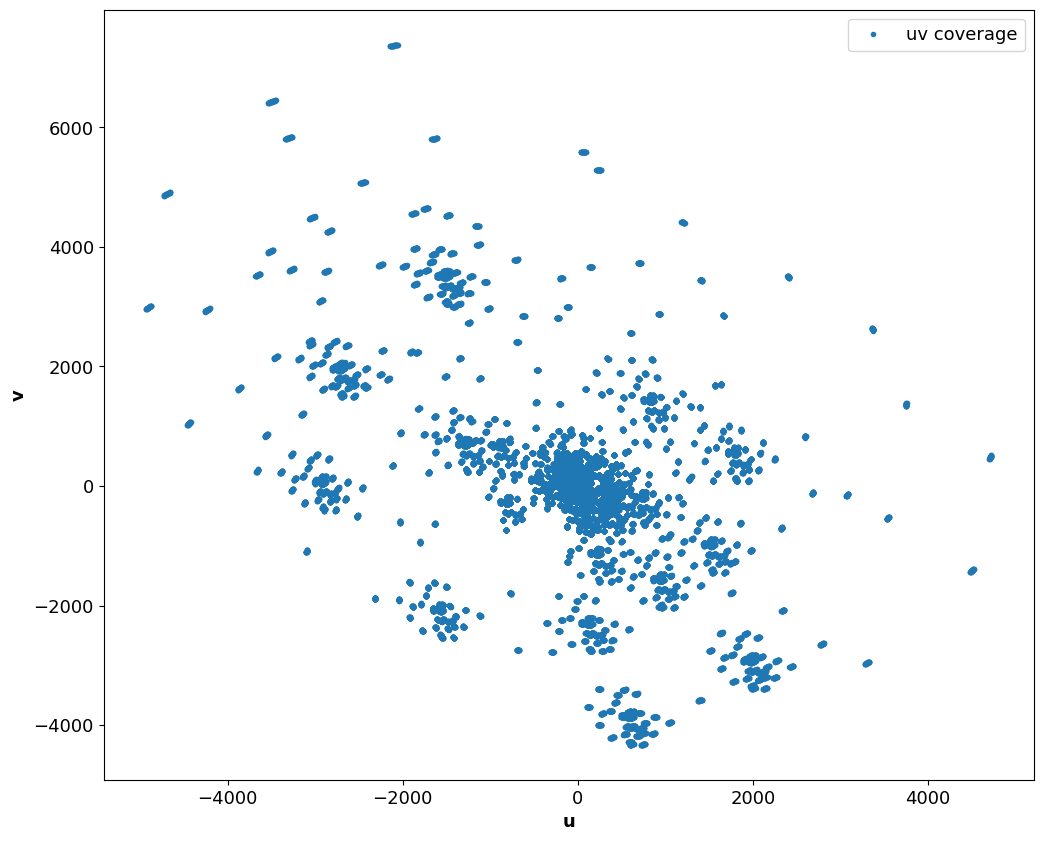

In [13]:
# Q2.1)
# Get the UVW points
ds = xds_from_table(data_path+"1548939342.ms")

ds[0]['UVW']
u,v,w = ds[0]['UVW'][:,0],ds[0]['UVW'][:,1],ds[0]['UVW'][:,2]

# plotting uv coverage:
plt.plot(u,v,'.', label = 'uv coverage')
plt.xlabel('u')
plt.ylabel('v')
plt.legend()
plt.show()

In [14]:
# To answer question 2.2) we need to have antenna position information:
# Acessing Antenna position information:
antenna_positions = antenna[0]['POSITION']

In [15]:
# Q2.2)
# Extract X, Y, Z positions from the antenna table
X, Y, Z = antenna_positions[:, 0], antenna_positions[:, 1], antenna_positions[:, 2]

# X,Y,Z values:
X_values = X.compute()
Y_values = Y.compute()
Z_values = Z.compute()

# Calculate the pairwise baselines
num_antennas = len(antenna_names)
baselines = np.zeros((num_antennas, num_antennas))

for i in range(num_antennas):
    for j in range(num_antennas):
        if i != j:  # here we skip self-baseline
            baselines[i, j] = np.sqrt((X_values[i] - X_values[j])**2 + 
                                       (Y_values[i] - Y_values[j])**2 + 
                                       (Z_values[i] - Z_values[j])**2)

# Find the indices of the longest and shortest baselines
longest_idx = np.unravel_index(np.argmax(baselines), baselines.shape)
shortest_idx = np.unravel_index(np.argmin(baselines[np.not_equal(baselines, 0.0)]), baselines.shape) # Avoids baseline between antenna itself

#Access the names of the antennas corresponding to the longest and shortest baselines
antenna_1_longest = antenna_names[longest_idx[0]]
antenna_2_longest = antenna_names[longest_idx[1]]
longest_baseline = baselines[longest_idx]

antenna_1_shortest = antenna_names[shortest_idx[0]]
antenna_2_shortest = antenna_names[shortest_idx[1]]
shortest_baseline = baselines[shortest_idx]

# Print the results
print(f"The longest baseline is between {antenna_1_longest} and {antenna_2_longest} with a length of {longest_baseline:.2f} meters.")
print(f"The shortest baseline is between {antenna_1_shortest} and {antenna_2_shortest} with a length of {shortest_baseline:.2f} meters.")
print()

The longest baseline is between m048 and m060 with a length of 7697.58 meters.
The shortest baseline is between m000 and m001 with a length of 36.75 meters.



In [16]:
# Q2.3)

wavelength = 3e8 / np.mean(frequencies)  # speed of light / frequency
resolution_short = wavelength / shortest_baseline
resolution_long = wavelength / longest_baseline

print(f"Resolution (short baseline): {resolution_short} radians")
print(f"Resolution (long baseline): {resolution_long} radians")

Resolution (short baseline): 0.00636031628807551 radians
Resolution (long baseline): 3.0362911639680014e-05 radians


In [17]:
# Q2.4)

# speed of light:
c = 3e8  # m/s

# Assuming theta is 0 for simplicity, so cos(theta) = 1
theta = 0  
cos_theta = np.cos(np.radians(theta))  # Convert to radians

# Calculate delays
shortest_delay = shortest_baseline *cos_theta/c 
longest_delay = longest_baseline*cos_theta /c

# Print results
print(f"Delay for the shortest baseline: {shortest_delay} seconds")
print(f"Delay for the longest baseline: {longest_delay} seconds")

Delay for the shortest baseline: 1.2248916052948647e-07 seconds
Delay for the longest baseline: 2.56585999417215e-05 seconds


In [18]:
# SPECTRAL table
spectral_table = xds_from_table(data_path+"1548939342.ms::SPECTRAL_WINDOW")

### Radion Frequency Interference (FRI)

Output saved by overwring previous file at channel_slice.jpg.


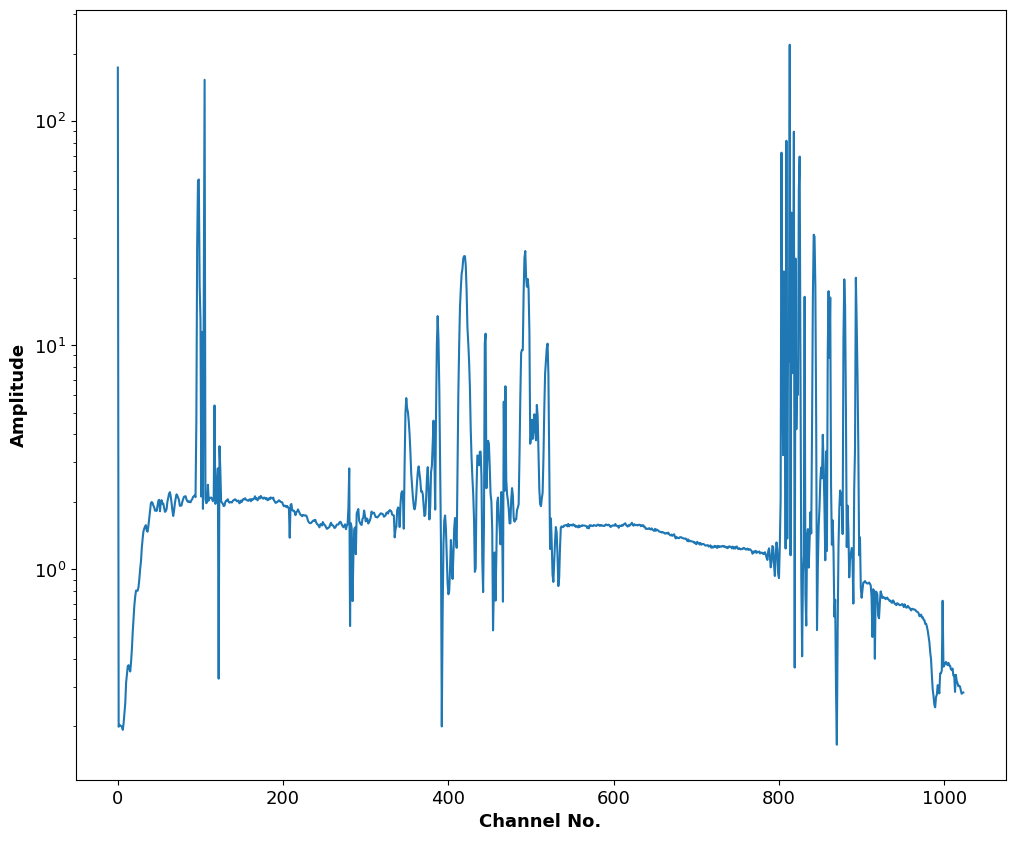

In [19]:
%%capture_img --path "channel_slice.jpg"
# 3.1) We arbitrarily choose baseline:

ds = xds_from_table(data_path+"1548939342.ms")

# Indices for antenna 1 and 2 where they make short baseline:
indx = np.where((ds[0]['ANTENNA1'] == 1) & (ds[0]['ANTENNA2'] == 2))[0]

# Extract the Dask array for the selected indices:
data_dask_array = ds[0].DATA.data[indx][5, :, 0]

# visibility line plot:
plt.plot(np.abs(data_dask_array)) 
plt.semilogy()  # Set y-axis to a log scale

# ploting the region 1:
plt.xlabel("Channel No.")
plt.ylabel("Amplitude")
plt.show()

Output saved by overwring previous file at freq_slice.jpg.


/tmp/ipykernel_12357/236516412.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.set_xticks(np.arange(freq[0]/1.e6,freq[-1]/1.e6,step=100))
/tmp/ipykernel_12357/236516412.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


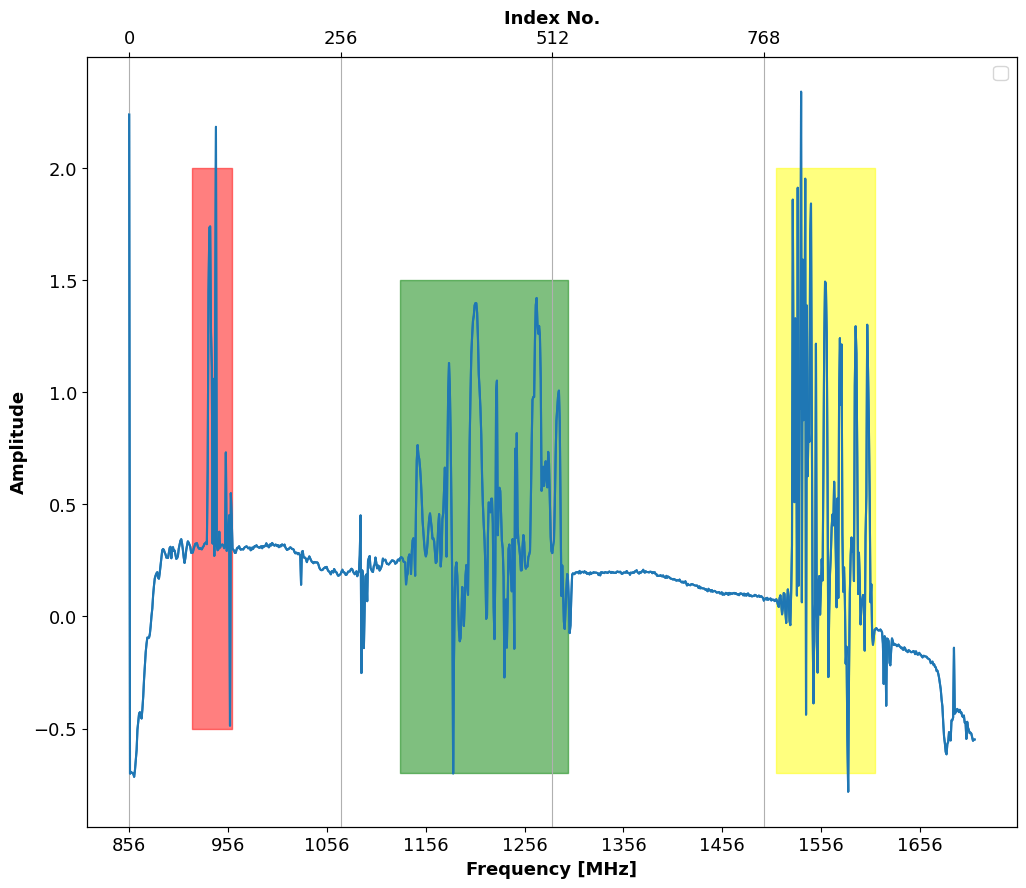

In [20]:
%%capture_img --path "freq_slice.jpg"
# Plot frequency slice
freq = spectral_table[0]['CHAN_FREQ'].values.T
absdata = np.abs(data_dask_array).compute()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(freq/1.e6, np.log10(absdata),'-')
ax1.set_xticks(np.arange(freq[0]/1.e6,freq[-1]/1.e6,step=100))
# label the RFI regions identified
ax1.fill_between((920,960),-0.5,2,alpha = 0.5, color = 'red',label='RFI 1')
ax1.fill_between((1130,1300),-0.7,1.5,alpha = 0.5,color = 'green', label='RFI 2')
ax1.fill_between((1510,1610),-0.7,2,alpha = 0.5,color = 'yellow', label='RFI 3')
ax1.set_xlabel('Frequency [MHz]')
ax1.set_ylabel('Amplitude')

ax2.plot(np.log10(absdata))
ax2.set_xticks(np.arange(0,absdata.shape[0],step=256))
ax2.set_xlabel('Index No.')
plt.legend()
plt.grid()
         

In [21]:
vis_clean = []
vis_rfi =[]

for a1 in range(0,10):
    for a2 in range(1,10):
        if a1 != a2:
            indx = np.where((ds[0].ANTENNA1 == a1) & (ds[0].ANTENNA2 == a2))[0]
            vis_clean.append(np.abs(ds[0].DATA.data[indx][:,700,0].compute()))
            vis_rfi.append(np.abs(ds[0].DATA.data[indx][:,850,0].compute()))

vis_clean_combined = np.concatenate(vis_clean)
vis_rfi_combined = np.concatenate(vis_rfi)

In [22]:
print(len(vis_clean_combined), len(vis_rfi_combined))

1125 1125


In [23]:
# vis_clean = []
# vis_rfi = []

# for a1 in range(0, 10):
#     for a2 in range(1, 10):
#         if a1 != a2:  # Ensure a1 and a2 are not the same antenna
#             indx = np.where((ds[0].ANTENNA1 == a1) & (ds[0].ANTENNA2 == a2))[0]
#             vis_clean.append(np.abs(ds[0].DATA.data[indx][:, 700, 0].compute()))
#             vis_rfi.append(np.abs(ds[0].DATA.data[indx][:, 850, 0].compute()))

# # Combine the results into single arrays
# vis_clean_combined = np.concatenate(vis_clean)
# vis_rfi_combined = np.concatenate(vis_rfi)


In [24]:
print(len(vis_clean_combined), len(vis_rfi_combined))

1125 1125


In [25]:
print(np.mean(vis_clean_combined ), np.mean(vis_rfi_combined))

2.0742145 2.3424363


Output saved by overwring previous file at hist_clean_rfi.jpg.


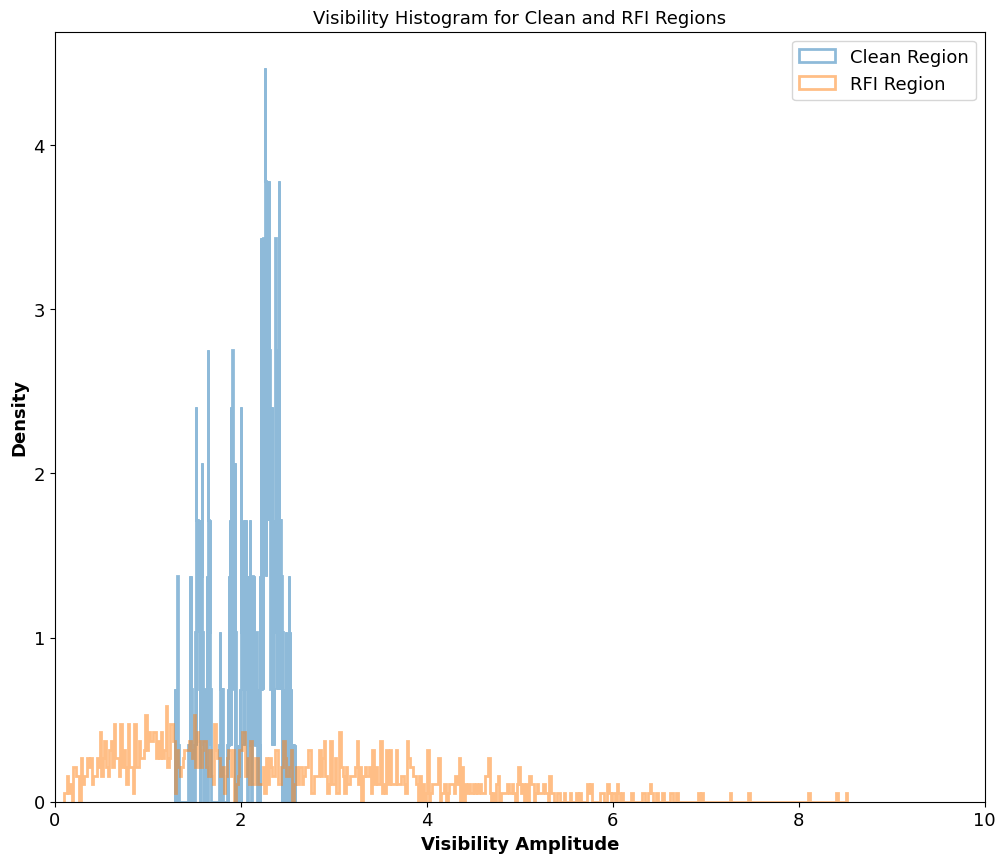

In [26]:
%%capture_img --path "hist_clean_rfi.jpg"
# histograms:
# histogram for vis_clean_combined:
plt.hist(vis_clean_combined,
        bins=500,
        alpha = 0.5,
        histtype = u'step',
        lw=2,
        label='Clean Region',
        density=True);
# histogram for vis_rfi_combined:
plt.hist(vis_rfi_combined,
        bins=500,
        alpha = 0.5,
        histtype = u'step',
        lw=2,
        label='RFI Region',
        density=True);
plt.xlabel('Visibility Amplitude')
plt.ylabel('Density')
plt.title('Visibility Histogram for Clean and RFI Regions')
plt.legend()
plt.xlim(0,10)
# Display the plot
plt.show()


In [27]:
# 3)
# Calculate the standard deviation for vis_clean_combined (clean region)
std_clean = np.std(vis_clean_combined)

# Calculate the standard deviation for vis_rfi_combined (contaminated region)
std_rfi = np.std(vis_rfi_combined)

# Print the resultsRFI
print(f"Standard Deviation (Clean Region): {std_clean:.2f}")
print(f"Standard Deviation (RFI Contaminated Region): {std_rfi:.2f}")

Standard Deviation (Clean Region): 0.32
Standard Deviation (RFI Contaminated Region): 1.53


In [28]:
# 4)
# Calculate skewness and kurtosis for clean region
skew_clean = skew(vis_clean_combined)
kurtosis_clean = kurtosis(vis_clean_combined,fisher=True)

# Calculate skewness and kurtosis for RFI region
skew_rfi = skew(vis_rfi_combined)
kurtosis_rfi = kurtosis(vis_rfi_combined,fisher=True)

print(f"Clean Region - Skewness: {skew_clean}, Kurtosis: {kurtosis_clean}")
print(f"RFI Region - Skewness: {skew_rfi}, Kurtosis: {kurtosis_rfi}")

Clean Region - Skewness: -0.7147394693272716, Kurtosis: -0.6487765517026771
RFI Region - Skewness: 0.8379072793808797, Kurtosis: 0.29967216153204346


# Visibility
#### visibility for longest baseline: We use  baseline from Question 1.2

Output saved by overwring previous file at longbase_vis.jpg.


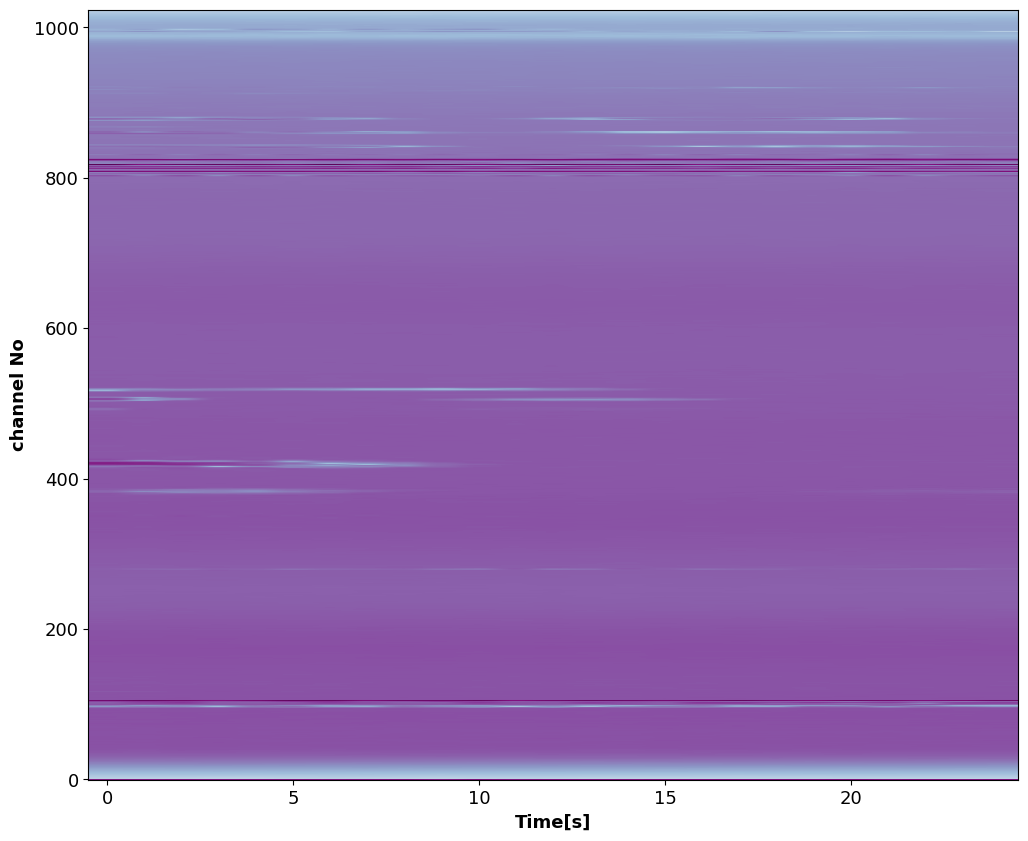

In [29]:
%%capture_img --path "longbase_vis.jpg"
# 5)
# long baseline visibility
# We use long baseline identified in Question 1.2)

ds = xds_from_table(data_path+"1548939342.ms")

indx = np.where((ds[0].ANTENNA1 ==  longest_idx[0]) & (ds[0].ANTENNA2 == longest_idx[1]))[0]
#ds[0].DATA.data[indx]

plt.imshow(np.abs(ds[0].DATA.data[indx][:,:,0]).T,
          aspect = 'auto',
          origin = 'lower',
          cmap = 'BuPu',
          norm = 'log'
          )
plt.xlabel("Time[s]")
plt.ylabel("channel No")
plt.show()

#### Visibility in terms of line plot: for long baseline with data sliced from the data used to generate the plot above:

Output saved by overwring previous file at longbase_1d.jpg.


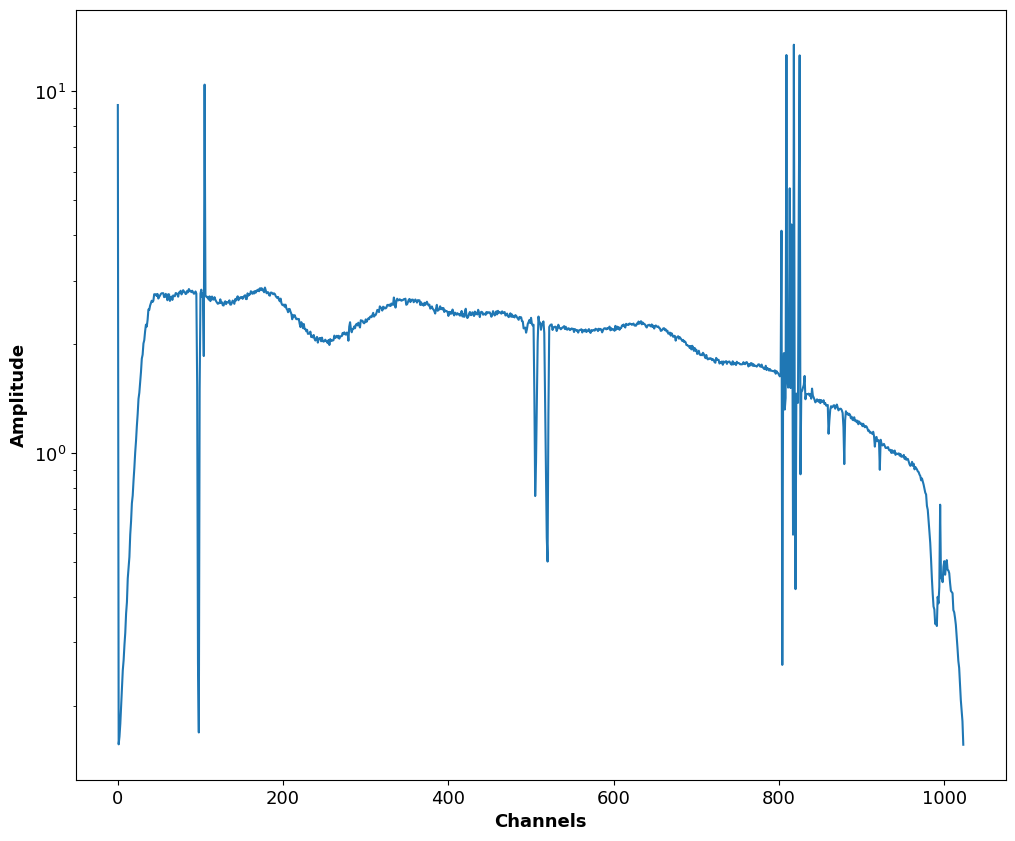

In [30]:
%%capture_img --path "longbase_1d.jpg"
# Indices for antenna 1 and 2 where they make short baseline:
indx = np.where((ds[0]['ANTENNA1'] == longest_idx[0]) & (ds[0]['ANTENNA2'] == longest_idx[1]))[0]

# Extract the Dask array for the selected indices:
data_dask_array = ds[0].DATA.data[indx][11, :, 0]

# plot visibility line plot:
plt.plot(np.abs(data_dask_array)) 
plt.semilogy()  # Set y-axis to a log scale

# Set plot labels
plt.ylabel('Amplitude')
plt.xlabel('Channels')
plt.show()

#### visibility for short baseline: We use short baseline from Question 1.2

Output saved by overwring previous file at shortbase_vis.jpg.


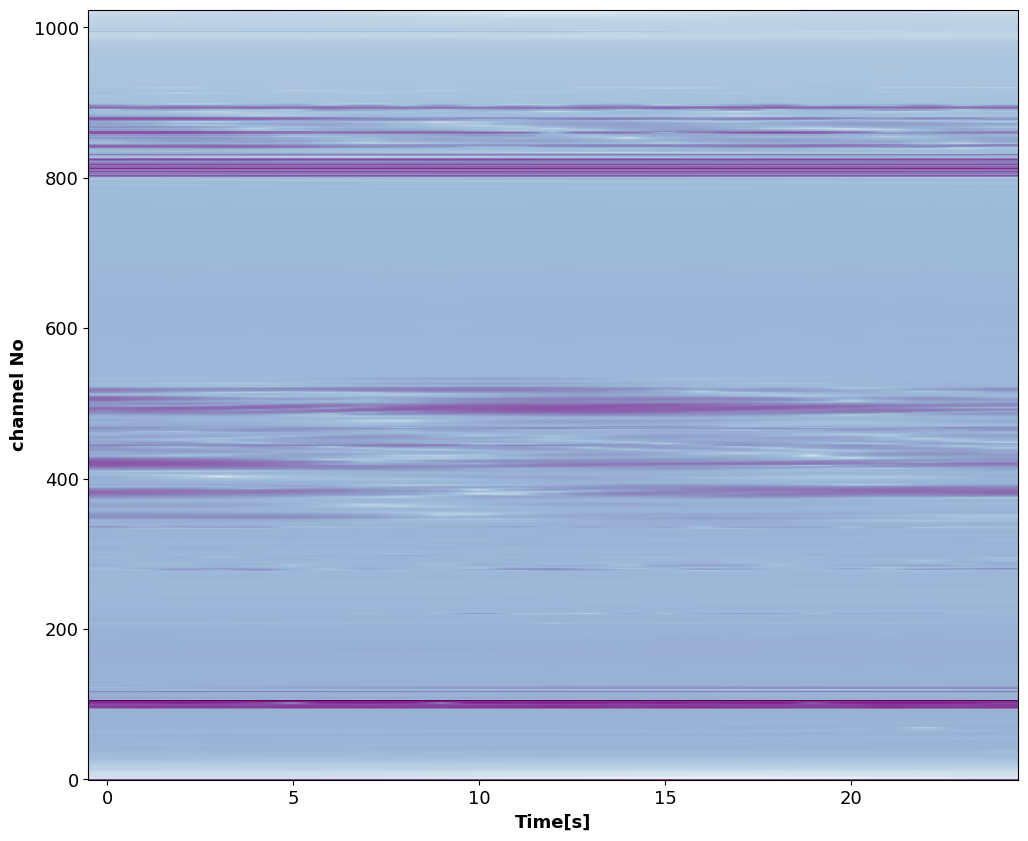

In [31]:
%%capture_img --path "shortbase_vis.jpg"
# short baseline visibility

ds = xds_from_table(data_path+"1548939342.ms")

indx = np.where((ds[0].ANTENNA1 ==  shortest_idx[0]) & (ds[0].ANTENNA2 == shortest_idx[1]))[0]
#ds[0].DATA.data[indx]

plt.imshow(np.abs(ds[0].DATA.data[indx][:,:,0]).T,
          aspect = 'auto',
          origin = 'lower',
          cmap = 'BuPu',
          norm = 'log'
          )
plt.xlabel("Time[s]")
plt.ylabel("channel No")
plt.show()

Output saved by overwring previous file at shortbase_1d.jpg.


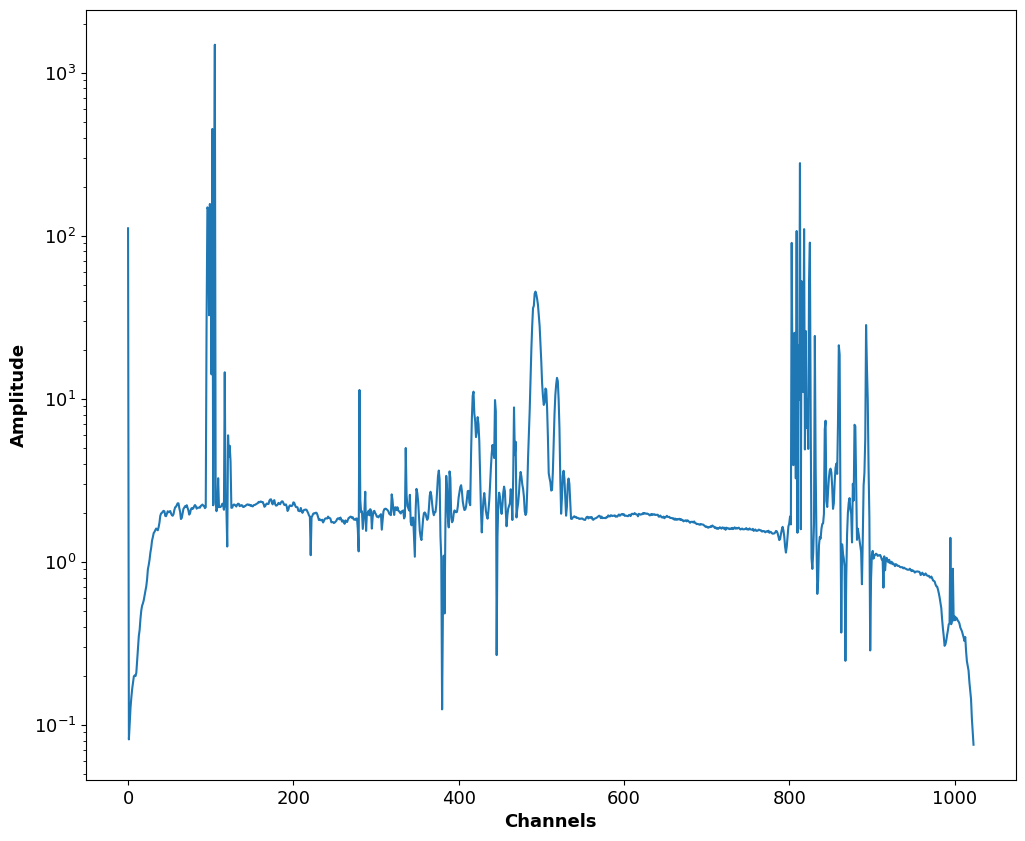

In [32]:
%%capture_img --path "shortbase_1d.jpg"
# Indices for antenna 1 and 2 where they make shortest baseline:
indx = np.where((ds[0]['ANTENNA1'] == shortest_idx[0]) & (ds[0]['ANTENNA2'] == shortest_idx[1]))[0]

# Extract the Dask array for the selected indices
data_dask_array = ds[0].DATA.data[indx][11, :, 0]

# plot visibility line plot:
plt.plot(np.abs(data_dask_array)) 
plt.semilogy()  # Set y-axis to a log scale

# Set plot labels
plt.ylabel('Amplitude')
plt.xlabel('Channels')
plt.show()

In [33]:
def Gauss(x, dc, a, x0, sigma):
    '''
    This will fit a gaussian function to a data set
    '''
    return dc+a * np.exp(-(x - x0)**2 / (2 * sigma**2))

Output saved by creating file at gaussian_hpbw.jpg.


Enter initial index for Gaussian fit  800
Enter final index for Gaussian fit  850


/tmp/ipykernel_12357/2953898589.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_new = np.arange(frequencies[ini_idx], frequencies[fin_idx],15)


FWHM [MHz] =  25.90248523878488
Maximum amplitude is at [db], 1.2260739238344773 
Maximum is at [MHz]  1536.544515
Number of channels affected 30


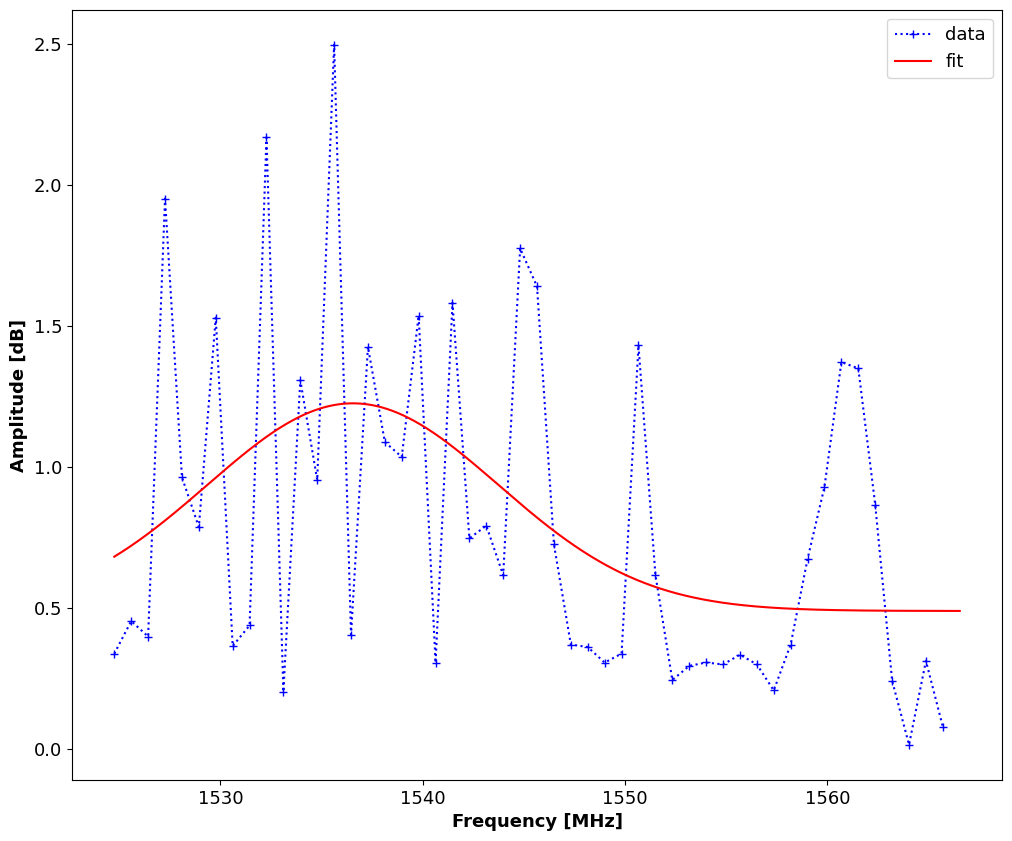

In [53]:
%%capture_img --path "gaussian_hpbw.jpg"
# 6)

frequencies = spectral_table[0]['CHAN_FREQ'].values.T
vis = ds[0]['DATA']
absdata = np.abs(vis[500,:,0]).compute()

ini_idx = int(input('Enter initial index for Gaussian fit '))
fin_idx = int(input('Enter final index for Gaussian fit '))

x = np.ravel(frequencies[ini_idx:fin_idx])
y = np.log10(np.abs(absdata[ini_idx:fin_idx]))

# weighted arithmetic mean (corrected - check the section below)
mean = (sum(x * y) / sum(y)).values
sigma = (np.sqrt(sum(y * (x - mean)**2) / sum(y))).values

dc = np.nanmean(np.log10(absdata[550:750]).values)-1

popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), dc, mean, sigma])

plt.plot(x/1e6, y, 'b+:', label='data')
x_new = np.arange(frequencies[ini_idx], frequencies[fin_idx],15)
plt.plot(x_new/1e6, Gauss(x_new, *popt), 'r-', label='fit')
plt.legend()

plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [MHz]')
plt.show()

print (f"FWHM [MHz] =  {(2.*np.sqrt(2.*np.log(2.))*sigma)/1.e6}")
print(f"Maximum amplitude is at [db], {max(Gauss(x_new, *popt))} ")
print (f"Maximum is at [MHz]  {x_new[np.argmax(Gauss(x_new, *popt))]/1.e6}")
print(f"Number of channels affected {int(((2.*np.sqrt(2.*np.log(2.))*sigma))/(channel_width*1.e3))}")

Output saved by overwring previous file at detrend_data.jpg.


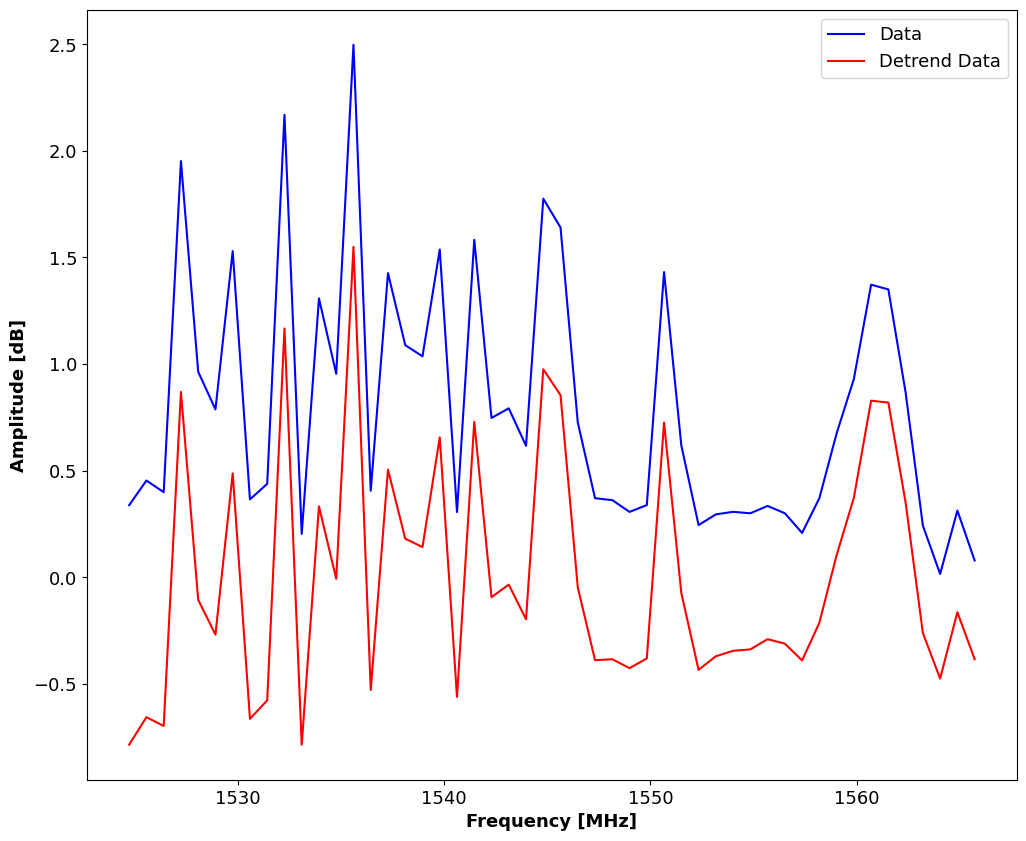

In [59]:
%%capture_img --path "detrend_data.jpg"
#10 Scipy detrending of the data
from scipy.signal import detrend
y_detr = detrend(y, type='linear')
plt.plot(x/1e6,y,'b', label = 'Data')
plt.plot(x/1e6,y_detr,'r',label = 'Detrend Data')
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [MHz]')
plt.legend()